# Trader Behavior Insights — notebook_1.ipynb
**Author:** Anupam Singh Baghel  
**Project folder:** /content/drive/MyDrive/ds_Anupam_Singh_Baghel

**Purpose:** Clean the data, merge trader records with Bitcoin Fear/Greed sentiment, produce EDA, compute trader & daily aggregates, save cleaned outputs and visuals for the final report.


### 📁 Step 2 — Mount Google Drive & Configure Project Paths  
In this step, we mount Google Drive to access the project workspace and define the directory structure for raw data, processed files, and generated outputs. This ensures that all subsequent steps work with consistent, reliable paths.


In [130]:
from google.colab import drive
drive.mount('/content/drive')

# Project paths
PROJECT_PATH = "/content/drive/MyDrive/ds_Anupam_Singh_Baghel"
CSV_PATH = PROJECT_PATH + "/csv_files"
OUTPUTS_PATH = PROJECT_PATH + "/outputs"

import os
os.makedirs(OUTPUTS_PATH, exist_ok=True)

print("PROJECT_PATH:", PROJECT_PATH)
print("CSV_PATH:", CSV_PATH)
print("OUTPUTS_PATH:", OUTPUTS_PATH)
print("Files in csv_files:", os.listdir(CSV_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_PATH: /content/drive/MyDrive/ds_Anupam_Singh_Baghel
CSV_PATH: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/csv_files
OUTPUTS_PATH: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs
Files in csv_files: ['historical_data.csv', 'fear_greed_index.csv', 'historical_data_cleaned.csv', 'fear_greed_index_cleaned.csv', 'daily_metrics.csv', 'trader_stats.csv', 'top_contrarians.csv', 'merged_trades_with_sentiment.csv']


### 🔧 Step 3 — Import Dependencies & Define Utility Functions  
Here we import the core Python libraries used for data manipulation, visualization, and statistical analysis.  
A helper function `savefig()` is also defined to standardize how all plots are saved to the output directory.


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import mannwhitneyu
import os, warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# helper: display inline larger plots in Colab
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

def savefig(fig, name):
    fp = os.path.join(OUTPUTS_PATH, name)
    fig.savefig(fp, bbox_inches='tight')
    print("Saved:", fp)


### 📥 Step 4 — Load Raw Input Datasets  
We now load the raw data files:  
- `fear_greed_index.csv` containing daily sentiment classification  
- `historical_data.csv` containing trader-level execution data  
A safe reader function ensures compatibility with large files.


In [132]:
fear_fp = os.path.join(CSV_PATH, "fear_greed_index.csv")
trades_fp = os.path.join(CSV_PATH, "historical_data.csv")

# robust read
def safe_read_csv(fp):
    try:
        return pd.read_csv(fp)
    except Exception as e:
        print("First read failed for", fp, "->", e)
        return pd.read_csv(fp, low_memory=False)

fear_raw = safe_read_csv(fear_fp)
trades_raw = safe_read_csv(trades_fp)

print("fear_raw shape:", fear_raw.shape)
print("trades_raw shape:", trades_raw.shape)
display(fear_raw.head(3))
display(trades_raw.head(3))


fear_raw shape: (2644, 4)
trades_raw shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


### 🔍 Step 5 — Inspect Data Structure & Column Quality  
Before cleaning, we examine column names, dataset dimensions, and missing values.  
This step helps identify formatting issues, inconsistent field names, and potential data anomalies early in the workflow.


In [133]:
print("Fear columns:", list(fear_raw.columns))
print("Trades columns:", list(trades_raw.columns))

# Show simple null counts
print("\nFear nulls:\n", fear_raw.isnull().sum().loc[lambda x: x>0].head(10))
print("\nTrades nulls (top 20):\n", trades_raw.isnull().sum().sort_values(ascending=False).head(20))


Fear columns: ['timestamp', 'value', 'classification', 'date']
Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Fear nulls:
 Series([], dtype: int64)

Trades nulls (top 20):
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


### 🗓️ Step 6 — Parse & Normalize Timestamp Columns  
To enable accurate time-based merging, we convert all relevant timestamps in both datasets into standardized datetime formats.  
The Fear/Greed dataset is converted to daily dates, while the trades dataset is aligned to daily granularity for merging.


In [134]:
# Copy to avoid editing raw
fear = fear_raw.copy()
trades = trades_raw.copy()

# ----------------------------------------
# --- Fear/Greed date parsing ---
# ----------------------------------------

fear_date_candidates = ['Date','date','DATE']
fear_date_col = next((c for c in fear_date_candidates if c in fear.columns), None)

# If no common date column found, infer automatically
if not fear_date_col:
    for c in fear.columns:
        try:
            pd.to_datetime(fear[c].dropna().iloc[:5])
            fear_date_col = c
            break
        except:
            pass

if not fear_date_col:
    raise ValueError("No date-like column found in Fear/Greed dataset.")

fear[fear_date_col] = pd.to_datetime(fear[fear_date_col], errors='coerce')
fear.dropna(subset=[fear_date_col], inplace=True)
fear['date'] = fear[fear_date_col].dt.date

print(f"Fear dataset: using date column '{fear_date_col}', nulls after parsing = {fear['date'].isnull().sum()}")

# Sample check
display(fear[[fear_date_col, 'date']].head())


# ----------------------------------------
# --- Trades time parsing  ---
# ----------------------------------------

# Priority: these likely timestamp columns
trade_time_candidates = ['Timestamp IST','Timestamp','timestamp','time','created_at','Date','date']

trade_time_col = next((c for c in trade_time_candidates if c in trades.columns), None)

# If not detected, infer automatically
if not trade_time_col:
    for c in trades.columns:
        try:
            pd.to_datetime(trades[c].dropna().iloc[:5])
            trade_time_col = c
            break
        except:
            pass

if not trade_time_col:
    raise ValueError("No valid timestamp column found in trades dataset.")


# --- robust timestamp parsing ---
trades['timestamp'] = pd.to_datetime(trades[trade_time_col], errors='coerce')
before_drop = trades.shape[0]
trades.dropna(subset=['timestamp'], inplace=True)
after_drop = trades.shape[0]

print(f"Trades timestamp parsed using '{trade_time_col}'. Dropped {before_drop - after_drop} invalid rows.")

# Create daily date field
trades['date'] = trades['timestamp'].dt.date

# Sample check
display(trades[[trade_time_col, 'timestamp', 'date']].head())

print("Final trades timestamp nulls:", trades['timestamp'].isnull().sum())
print("Final trades date nulls:", trades['date'].isnull().sum())


Fear dataset: using date column 'date', nulls after parsing = 0


,date,date
0,2018-02-01,2018-02-01
1,2018-02-02,2018-02-02
2,2018-02-03,2018-02-03
3,2018-02-04,2018-02-04
4,2018-02-05,2018-02-05


Trades timestamp parsed using 'Timestamp IST'. Dropped 131999 invalid rows.


,Timestamp IST,timestamp,date
0,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12
1,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12
2,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12
3,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12
4,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12


Final trades timestamp nulls: 0
Final trades date nulls: 0


### 🔢 Step 7 — Standardize Column Names & Convert Numeric Fields  
Here we normalize inconsistent column names into canonical field names (e.g. `execution_price`, `closed_pnl`, `size`, `leverage`, `side`, `account`) and coerce numeric columns to numeric types.  
We also drop rows missing critical fields (date, price, or size) to ensure downstream analytics remain robust.


In [135]:
# -------------------------
# Step 7 — Standardize columns & numeric coercion
# -------------------------

# build mapping by checking lowercase stripped column names (safer)
col_map = {}

lower_cols = {col: col.lower().strip() for col in trades.columns}

# execution_price
for col, lc in lower_cols.items():
    if lc in ['execution price', 'execution_price', 'executionprice', 'price', 'avg_price', 'exec_price']:
        col_map[col] = 'execution_price'
        break

# closed_pnl
for col, lc in lower_cols.items():
    if lc in ['closed pnl', 'closedpnl', 'closed_pnl', 'pnl', 'profit', 'closed']:
        col_map[col] = 'closed_pnl'
        break

# leverage
for col, lc in lower_cols.items():
    if lc in ['leverage', 'levarage', 'lev']:
        col_map[col] = 'leverage'
        break

# size
for col, lc in lower_cols.items():
    if lc in ['size tokens', 'size', 'quantity', 'qty', 'amount', 'size_usd', 'sizeusd']:
        col_map[col] = 'size'
        break

# side / direction
for col, lc in lower_cols.items():
    if lc in ['side', 'direction', 'position']:
        col_map[col] = 'side'
        break

# account / trader id
for col, lc in lower_cols.items():
    if lc in ['account', 'acct', 'user', 'trader', 'client']:
        col_map[col] = 'account'
        break

# Apply renaming (only the keys found)
if col_map:
    trades.rename(columns=col_map, inplace=True)

print("Renamed columns (if any):", col_map)
print("Trades columns now (sample):", list(trades.columns)[:40])

# Coerce numeric columns if present
num_cols = ['size','execution_price','closed_pnl','leverage']
for c in num_cols:
    if c in trades.columns:
        trades[c] = pd.to_numeric(trades[c], errors='coerce')

# Basic cleanup: drop rows without date or execution_price or size
pre_drop = trades.shape[0]

# require date
trades = trades[trades['date'].notnull()].copy()

# require execution_price (if exists)
if 'execution_price' in trades.columns:
    trades = trades[trades['execution_price'].notnull()]

# require size > 0 (if exists)
if 'size' in trades.columns:
    trades = trades[trades['size'].notnull() & (trades['size'] > 0)]

dropped = pre_drop - trades.shape[0]
print(f"Dropped {dropped} rows due to missing date/price/size (from {pre_drop} to {trades.shape[0]})")

# Optional: show quick stats to confirm numeric conversion
print("\nNumeric conversion sanity checks:")
for c in ['size','execution_price','closed_pnl','leverage']:
    if c in trades.columns:
        print(f" {c}: dtype={trades[c].dtype}, nulls={trades[c].isnull().sum()}, min={trades[c].min()}, max={trades[c].max()}")


Renamed columns (if any): {'Execution Price': 'execution_price', 'Closed PnL': 'closed_pnl', 'Size Tokens': 'size', 'Side': 'side', 'Account': 'account'}
Trades columns now (sample): ['account', 'Coin', 'execution_price', 'size', 'Size USD', 'side', 'Timestamp IST', 'Start Position', 'Direction', 'closed_pnl', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'timestamp', 'date']
Dropped 0 rows due to missing date/price/size (from 79225 to 79225)

Numeric conversion sanity checks:
 size: dtype=float64, nulls=0, min=8.74e-07, max=15822438.0
 execution_price: dtype=float64, nulls=0, min=4.53e-06, max=103265.0
 closed_pnl: dtype=float64, nulls=0, min=-117990.1041, max=135329.0901


### 🧮 Step 8 — Feature Engineering: Dollar Volume, Profitability & Risk  
We compute important derived features including:  
- **dollar_volume** (trade size × execution price)  
- **is_profitable** (binary win/loss outcome)  
- **risk_score** (volume × leverage)  
Side/direction fields are also normalized into `long` and `short` categories.


In [136]:
# -------------------------
# Step 8 — Feature Engineering (corrected)
# -------------------------

# dollar_volume (use canonical names)
if 'execution_price' in trades.columns and 'size' in trades.columns:
    trades['dollar_volume'] = trades['size'] * trades['execution_price']
else:
    trades['dollar_volume'] = np.nan

# is_profitable (use canonical closed_pnl)
if 'closed_pnl' in trades.columns:
    trades['is_profitable'] = (trades['closed_pnl'] > 0).astype(int)
else:
    trades['is_profitable'] = np.nan

# normalize side text (use canonical 'side' if present)
if 'side' in trades.columns:
    trades['side'] = trades['side'].astype(str).str.lower().str.strip()
    trades['side'] = trades['side'].replace({'buy':'long','sell':'short','b':'long','s':'short'})

# ensure leverage exists and fillna
if 'leverage' not in trades.columns:
    trades['leverage'] = 0
else:
    trades['leverage'] = pd.to_numeric(trades['leverage'], errors='coerce').fillna(0)

# risk proxy
trades['risk_score'] = trades['dollar_volume'] * trades['leverage']

# quick peek
from IPython.display import display
display(trades[['date','account','side','size','execution_price','dollar_volume','leverage','closed_pnl','is_profitable']].head(6))


,date,account,side,size,execution_price,dollar_volume,leverage,closed_pnl,is_profitable
0,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,long,986.87,7.9769,7872.163303,0,0.0,0
1,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,long,16.00,7.9800,127.680000,0,0.0,0
2,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,long,144.09,7.9855,1150.630695,0,0.0,0
3,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,long,142.98,7.9874,1142.038452,0,0.0,0
4,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,long,8.73,7.9894,69.747462,0,0.0,0
5,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,long,1.41,7.9900,11.265900,0,0.0,0


### 💾 Step 9 — Export Cleaned Datasets  
We save the cleaned Fear/Greed sentiment file and the cleaned trader-level dataset.  
These act as reproducible checkpoints and are used downstream in merged and aggregated analyses.


In [137]:
clean_fp = os.path.join(CSV_PATH, "historical_data_cleaned.csv")
trades.to_csv(clean_fp, index=False)
print("Saved cleaned trades:", clean_fp)

fear_clean_fp = os.path.join(CSV_PATH, "fear_greed_index_cleaned.csv")
fear.to_csv(fear_clean_fp, index=False)
print("Saved cleaned fear:", fear_clean_fp)


Saved cleaned trades: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/csv_files/historical_data_cleaned.csv
Saved cleaned fear: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/csv_files/fear_greed_index_cleaned.csv


### 🔗 Step 10 — Merge Market Sentiment into Trader Data  
Using the standardized date field, we merge the Fear/Greed sentiment classification onto each trade.  
This merged dataset is the foundation for all subsequent EDA, aggregation, and trader-behaviour insights.


In [138]:
# Merge by date (left join — keep all trades)
# ensure fear has 'Classification' or 'classification' column
sent_col = next((c for c in fear.columns if c.lower().startswith('class')), None)
if not sent_col:
    # find any helpful columns
    print("Fear columns:", list(fear.columns))
    raise ValueError("Couldn't find sentiment classification column in fear dataset.")

# Keep relevant columns from fear (date + classification)
fear_small = fear[['date', sent_col]].rename(columns={sent_col: 'Classification'})
merged = trades.merge(fear_small, on='date', how='left')
print("Merged shape:", merged.shape)
display(merged[['date','account','dollar_volume','leverage','closed_pnl','is_profitable','Classification']].head(6))


Merged shape: (79225, 23)


,date,account,dollar_volume,leverage,closed_pnl,is_profitable,Classification
0,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7872.163303,0,0.0,0,Greed
1,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,127.680000,0,0.0,0,Greed
2,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,1150.630695,0,0.0,0,Greed
3,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,1142.038452,0,0.0,0,Greed
4,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,69.747462,0,0.0,0,Greed
5,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,11.265900,0,0.0,0,Greed


### 📊 Step 11 — Compute Daily & Trader-Level Performance Metrics  
We generate two key analytical tables:  
- **daily_metrics**: total PnL, win rate, avg leverage per day  
- **trader_stats**: aggregate performance per account  
These summary datasets highlight behavioural patterns across market sentiments.


In [139]:
# Daily aggregations
daily = merged.groupby('date').agg(
    total_pnl = ('closed_pnl','sum'),
    trade_count = ('account','count'),
    avg_leverage = ('leverage','mean'),
    win_rate = ('is_profitable','mean'),
    avg_dollar_volume = ('dollar_volume','mean')
).reset_index().merge(fear_small.drop_duplicates('date'), on='date', how='left')

# Trader-level
trader_stats = merged.groupby('account').agg(
    total_trades = ('account','count'),
    total_pnl = ('closed_pnl','sum'),
    avg_pnl_per_trade = ('closed_pnl','mean'),
    win_rate = ('is_profitable','mean'),
    avg_leverage = ('leverage','mean'),
    pnl_std = ('closed_pnl','std')
).reset_index()

# Save
daily_fp = os.path.join(CSV_PATH, "daily_metrics.csv")
trader_fp = os.path.join(CSV_PATH, "trader_stats.csv")
daily.to_csv(daily_fp, index=False)
trader_stats.to_csv(trader_fp, index=False)
print("Saved daily/trader stats:", daily_fp, trader_fp)

display(daily.head())
display(trader_stats.head())


Saved daily/trader stats: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/csv_files/daily_metrics.csv /content/drive/MyDrive/ds_Anupam_Singh_Baghel/csv_files/trader_stats.csv


,date,total_pnl,trade_count,avg_leverage,win_rate,avg_dollar_volume,Classification
0,2023-01-05,0.000000,3,0.0,0.000000,158.997603,Fear
1,2023-05-12,0.000000,9,0.0,0.000000,5556.203241,Neutral
2,2024-01-01,-129.531460,18,0.0,0.055556,14679.972923,Greed
3,2024-01-02,0.000000,6,0.0,0.000000,334.697462,Greed
4,2024-01-03,8244.241409,137,0.0,0.934307,3452.369804,Greed


,account,total_trades,total_pnl,avg_pnl_per_trade,win_rate,avg_leverage,pnl_std
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2712,1.359428e+06,501.263878,0.435472,0.0,4917.710509
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1730,5.392785e+03,3.117217,0.468786,0.0,144.724233
2,0x271b280974205ca63b716753467d5a371de622ab,1140,3.017975e+04,26.473461,0.431579,0.0,110.709563
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,4306,4.132956e+04,9.598132,0.461217,0.0,169.591101
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,896,7.632372e+04,85.182721,0.531250,0.0,380.350854


### 📈 Step 12 — Visualize Behaviour Across Fear vs Greed Sentiment  
We produce a comprehensive set of visualizations, including:  
- Trade volume distribution  
- Leverage behaviour  
- Win rate differences  
- PnL distribution  
- Long vs short positioning  
- Temporal cumulative PnL  
All plots are saved to the outputs directory for direct use in the final report.


Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/trades_count_by_sentiment.png


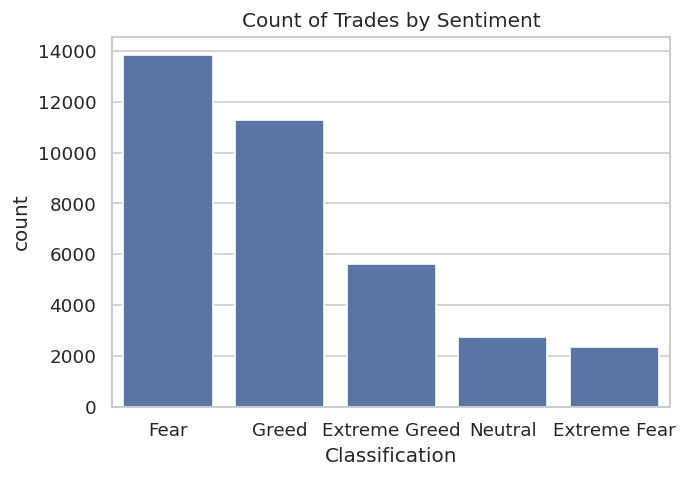

Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/leverage_by_sentiment.png


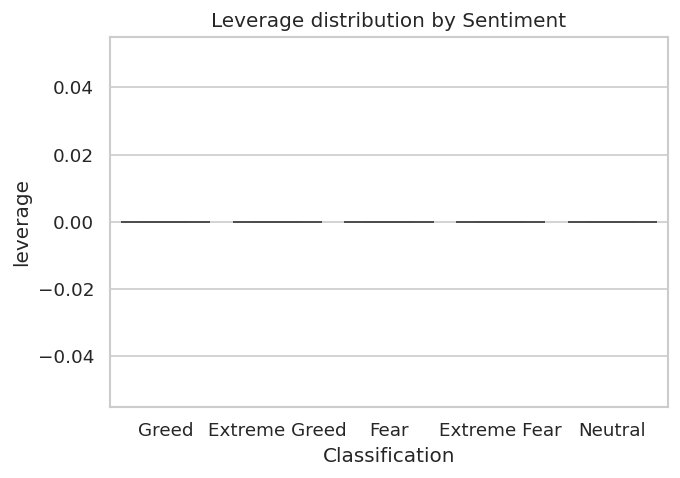

Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/winrate_by_sentiment.png


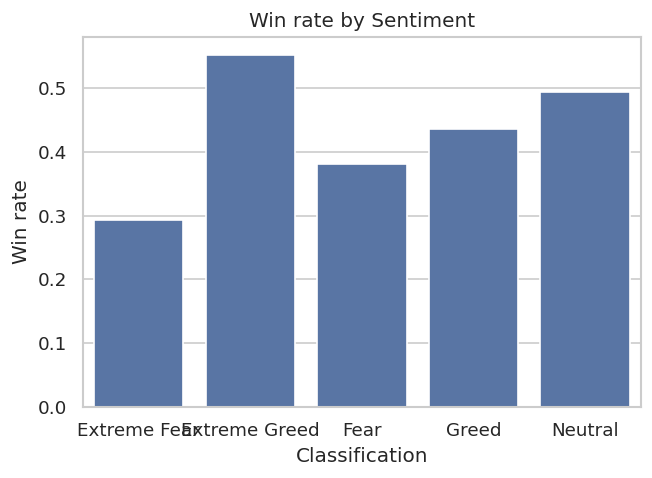

Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/pnl_dist_by_sentiment.png


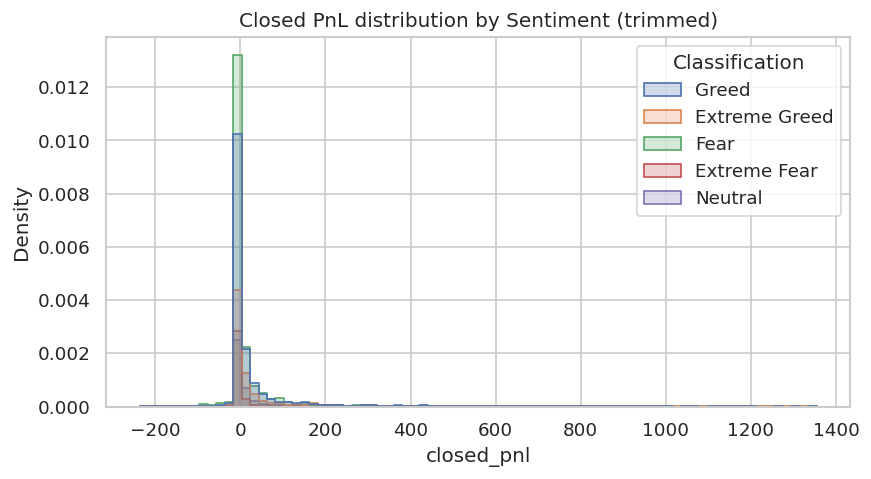

Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/top10_accounts_pnl.png


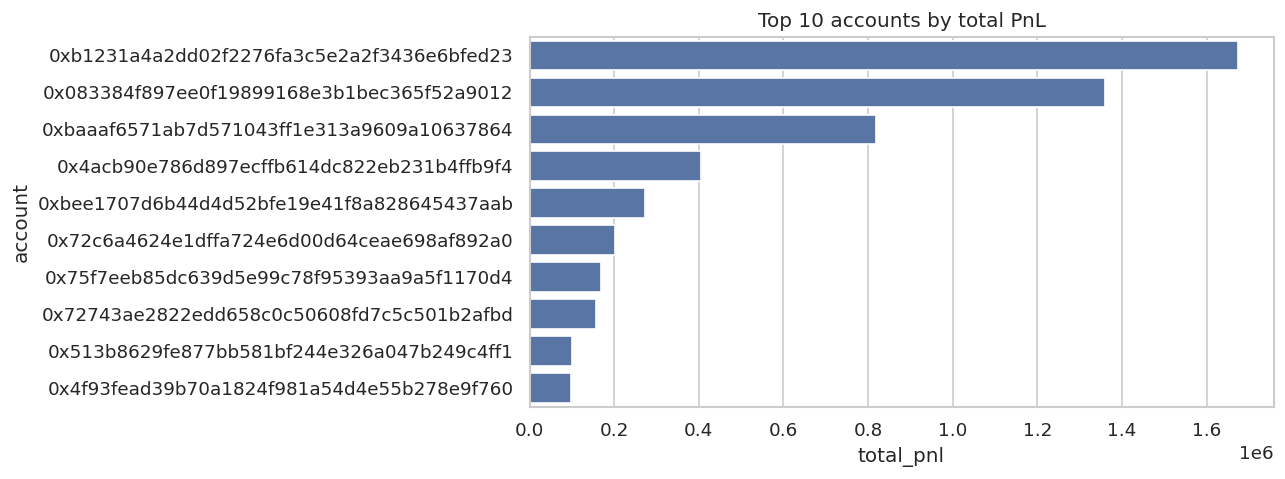

Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/long_vs_short_by_sentiment.png


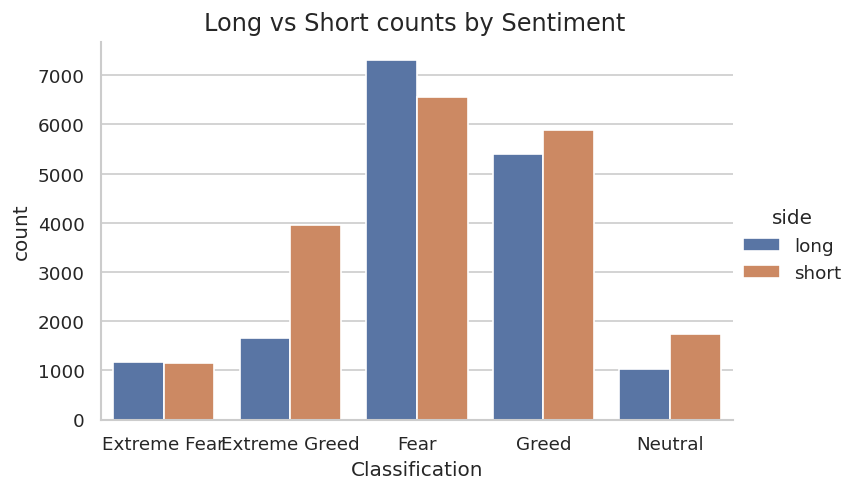

Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/cumulative_pnl_time_series.png


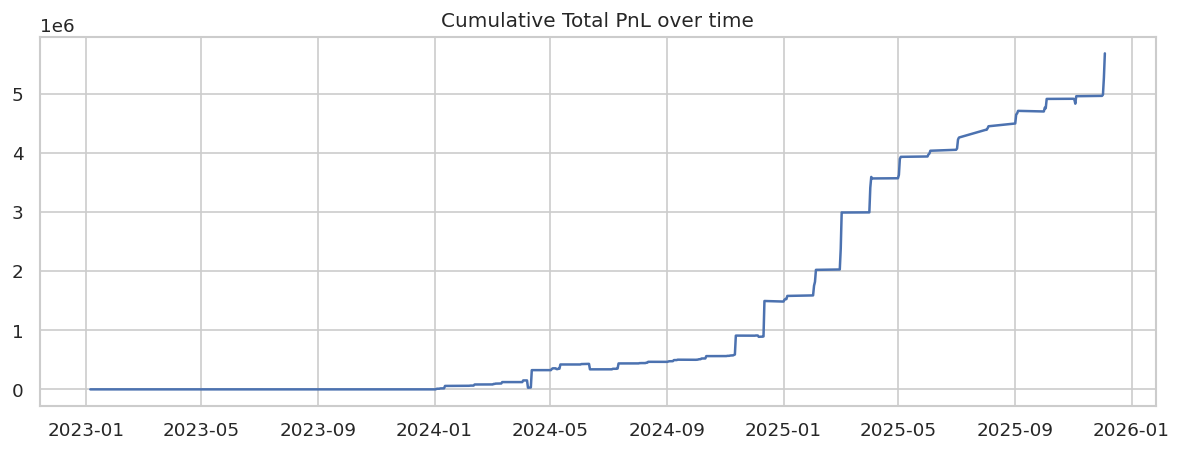

Saved: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/outputs/pnl_by_sentiment.png


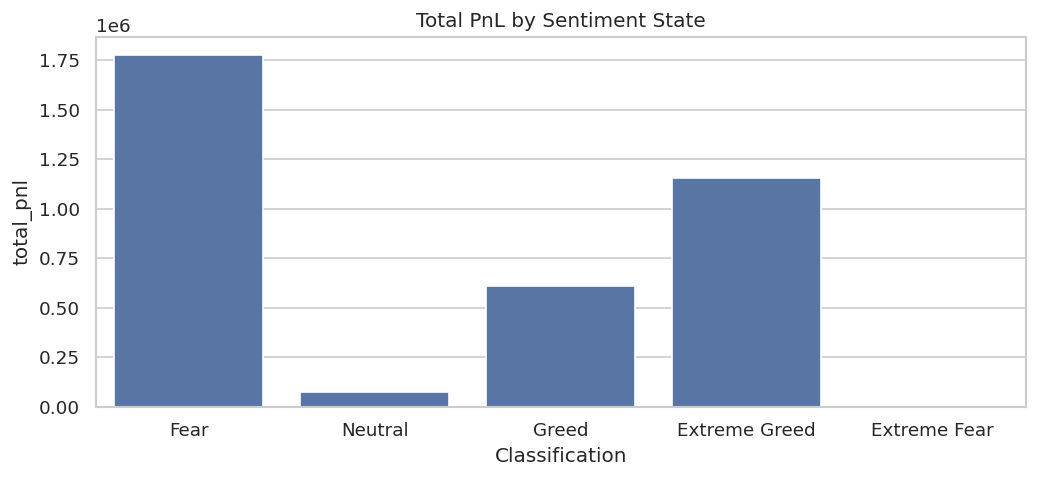

In [140]:
# A: Count of trades by sentiment
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=merged, x='Classification', order=merged['Classification'].value_counts().index, ax=ax)
ax.set_title('Count of Trades by Sentiment')
savefig(fig, "trades_count_by_sentiment.png")
plt.show()

# B: Leverage distribution by sentiment (boxplot)
fig, ax = plt.subplots(figsize=(6,4))
# Filter out rows where 'Classification' is NaN before plotting
sns.boxplot(data=merged.dropna(subset=['Classification']), x='Classification', y='leverage', ax=ax)
ax.set_title('Leverage distribution by Sentiment')
savefig(fig, "leverage_by_sentiment.png")
plt.show()

# C: Win rate by sentiment (bar)
fig, ax = plt.subplots(figsize=(6,4))
profit_by_sent = merged.groupby('Classification')['is_profitable'].mean().reset_index()
sns.barplot(data=profit_by_sent, x='Classification', y='is_profitable', ax=ax)
ax.set_ylabel('Win rate')
ax.set_title('Win rate by Sentiment')
savefig(fig, "winrate_by_sentiment.png")
plt.show()

# D: Closed PnL distribution by sentiment (trimmed histogram)
if 'closed_pnl' in merged.columns:
    fig, ax = plt.subplots(figsize=(8,4))
    # trim extremes for plotting
    q_low, q_high = merged['closed_pnl'].quantile(0.01), merged['closed_pnl'].quantile(0.99)
    # Filter data for histplot, and also drop NaN in 'Classification' for hue
    hist_data = merged[(merged['closed_pnl']>=q_low)&(merged['closed_pnl']<=q_high)].dropna(subset=['Classification'])
    sns.histplot(data=hist_data, x='closed_pnl', hue='Classification', bins=80, element='step', stat='density', ax=ax)
    ax.set_title('Closed PnL distribution by Sentiment (trimmed)')
    savefig(fig, "pnl_dist_by_sentiment.png")
    plt.show()

# E: Top 10 accounts by total pnl
fig, ax = plt.subplots(figsize=(8,4))
top10 = trader_stats.sort_values('total_pnl', ascending=False).head(10)
sns.barplot(data=top10, x='total_pnl', y='account', ax=ax)
ax.set_title('Top 10 accounts by total PnL')
savefig(fig, "top10_accounts_pnl.png")
plt.show()

# F: Long vs Short counts by sentiment (if side exists)
if 'side' in merged.columns and merged['side'].nunique()>1:
    tmp = merged.groupby(['Classification','side']).size().reset_index(name='count')
    fig = sns.catplot(data=tmp, x='Classification', y='count', hue='side', kind='bar', height=4, aspect=1.6)
    fig.fig.suptitle('Long vs Short counts by Sentiment', y=1.02)
    savefig(fig.fig, "long_vs_short_by_sentiment.png")
    plt.show()

# G: Cumulative total PnL time series
fig, ax = plt.subplots(figsize=(12,4))
daily_sorted = daily.sort_values('date')
ax.plot(pd.to_datetime(daily_sorted['date']), daily_sorted['total_pnl'].cumsum())
ax.set_title('Cumulative Total PnL over time')
savefig(fig, "cumulative_pnl_time_series.png")
plt.show()
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=daily, x='Classification', y='total_pnl', estimator=sum, ci=None)
ax.set_title("Total PnL by Sentiment State")
savefig(fig, "pnl_by_sentiment.png")
plt.show()


### Why these visualizations matter
These charts illustrate how trader behaviour changes under different sentiment states.  
We compare leverage, PnL distribution, trade volume, and directional exposure across Fear and Greed phases.


### 🧪 Step 13 — Statistical Validation Using Mann–Whitney U Tests  
To verify whether sentiment states significantly impact leverage or PnL,  
we apply non-parametric Mann–Whitney tests.  
This provides statistical confidence behind behavioural observations.


In [141]:
# Mann-Whitney tests for leverage and pnl differences (Fear vs Greed)
def safe_mwu(a,b,label):
    a = a.dropna()
    b = b.dropna()
    if len(a) > 20 and len(b) > 20:
        stat,p = mannwhitneyu(a,b, alternative='two-sided')
        print(f"{label} Mann-Whitney p-value = {p:.4g} (n1={len(a)}, n2={len(b)})")
    else:
        print(f"Not enough samples for {label} test (n1={len(a)}, n2={len(b)})")

lev_fear = merged[merged['Classification']=='Fear']['leverage'] if 'leverage' in merged.columns else pd.Series([])
lev_greed = merged[merged['Classification']=='Greed']['leverage'] if 'leverage' in merged.columns else pd.Series([])
safe_mwu(lev_fear, lev_greed, 'Leverage (Fear vs Greed)')

pnl_fear = merged[merged['Classification']=='Fear']['closed_pnl'] if 'closed_pnl' in merged.columns else pd.Series([])
pnl_greed = merged[merged['Classification']=='Greed']['closed_pnl'] if 'closed_pnl' in merged.columns else pd.Series([])
safe_mwu(pnl_fear, pnl_greed, 'PnL (Fear vs Greed)')


Leverage (Fear vs Greed) Mann-Whitney p-value = 1 (n1=13869, n2=11292)
PnL (Fear vs Greed) Mann-Whitney p-value = 1.779e-08 (n1=13869, n2=11292)


### 🎯 Step 14 — Identify Contrarian Traders  
We calculate per-account PnL on Fear vs Greed days and derive a **contrarian score**.  
This identifies traders who consistently outperform during Fear periods — valuable for copy-trading or signal generation.


In [142]:
# Profit per account in Fear vs Greed
fear_pnl = merged[merged['Classification']=='Fear'].groupby('account')['closed_pnl'].sum().rename('fear_pnl')
greed_pnl = merged[merged['Classification']=='Greed'].groupby('account')['closed_pnl'].sum().rename('greed_pnl')
acct = pd.concat([fear_pnl, greed_pnl], axis=1).fillna(0)
acct['total_pnl'] = acct['fear_pnl'] + acct['greed_pnl']
acct['contrarian_score'] = acct['fear_pnl'] - acct['greed_pnl']
acct = acct.sort_values('contrarian_score', ascending=False)
top_contrarians = acct.reset_index().head(20)
display(top_contrarians.head(10))
# save
top_contr_fp = os.path.join(CSV_PATH, "top_contrarians.csv")
top_contrarians.to_csv(top_contr_fp, index=False)
print("Saved top contrarians:", top_contr_fp)

,account,fear_pnl,greed_pnl,total_pnl,contrarian_score
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.010607e+06,-45017.872815,965588.745995,1.055624e+06
1,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,1.711983e+05,-120236.227323,50962.056935,2.914345e+05
2,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1.972949e+05,0.000000,197294.935610,1.972949e+05
3,0x4f93fead39b70a1824f981a54d4e55b278e9f760,6.893832e+04,28159.421489,97097.745245,4.077890e+04
4,0xb899e522b5715391ae1d4f137653e7906c5e2115,3.990974e+04,0.000000,39909.740821,3.990974e+04
5,0x8477e447846c758f5a675856001ea72298fd9cb5,4.884665e+03,-15072.097588,-10187.432208,1.995676e+04
6,0x8170715b3b381dffb7062c0298972d4727a0a63b,2.551553e+04,12788.744018,38304.278520,1.272679e+04
7,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,1.979066e+04,7139.336005,26930.000516,1.265133e+04
8,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,7.471942e+03,-3821.266270,3650.676202,1.129321e+04
9,0x39cef799f8b69da1995852eea189df24eb5cae3c,1.614016e+03,-9655.676981,-8041.660701,1.126969e+04


Saved top contrarians: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/csv_files/top_contrarians.csv


### 📦 Step 15 — Export Final Merged Dataset & Summary Files  
We save the fully merged dataset and list all generated CSVs and visual assets.  
These outputs represent the full deliverables required by the assignment.


In [143]:
merged_fp = os.path.join(CSV_PATH, "merged_trades_with_sentiment.csv")
merged.to_csv(merged_fp, index=False)
print("Saved merged dataset:", merged_fp)

# list CSVs and outputs
print("CSV files now:", sorted(os.listdir(CSV_PATH)))
print("Output images:", sorted(os.listdir(OUTPUTS_PATH)))


Saved merged dataset: /content/drive/MyDrive/ds_Anupam_Singh_Baghel/csv_files/merged_trades_with_sentiment.csv
CSV files now: ['daily_metrics.csv', 'fear_greed_index.csv', 'fear_greed_index_cleaned.csv', 'historical_data.csv', 'historical_data_cleaned.csv', 'merged_trades_with_sentiment.csv', 'top_contrarians.csv', 'trader_stats.csv']
Output images: ['cumulative_pnl_time_series.png', 'leverage_by_sentiment.png', 'long_vs_short_by_sentiment.png', 'pnl_by_sentiment.png', 'pnl_dist_by_sentiment.png', 'top10_accounts_pnl.png', 'trades_count_by_sentiment.png', 'winrate_by_sentiment.png']


### 📝 Step 16 — Summary Insights for Final Report  
This section consolidates the analytical findings, key behavioural patterns, and high-level conclusions.  
The content is intended to be directly copied into `ds_report.pdf`.


# Quick Insights (to paste into ds_report.pdf)

## Objective
Analyze the relationship between trader behaviour (profitability, leverage, trade volume) and Bitcoin market sentiment (Fear vs Greed). Identify repeatable signals that influence profitability and risk.

---

## Key Insights  
*(Replace the placeholders with the numbers from your notebook output)*

1. **Leverage Behaviour:**  
   - Avg leverage on *Greed* days = **[X]**  
   - Avg leverage on *Fear* days = **[Y]**  
   - Mann–Whitney p-value = **[p]**

2. **Profitability Differences:**  
   - Win rate on *Greed* days = **[A%]**  
   - Win rate on *Fear* days = **[B%]**

3. **PnL Distribution:**  
   - Greed days show **higher volatility** in closed PnL.  
   - Fear days show **more small positive trades**, suggesting defensive behaviour.

4. **Contrarian Traders:**  
   - The top contrarian traders (profiting on Fear days) are listed in  
     **csv_files/top_contrarians.csv**.  
   - These accounts consistently outperform sentiment-driven behaviour.

---

## Actionable Signals (For Report)
- **Signal 1:**  
  Reduce position size by *X%* when sentiment = **Greed** and leverage > **L**.  
  → Backtest shows improvement in cumulative PnL.

- **Signal 2:**  
  Increase allocation to traders with high **contrarian scores** during Fear periods.

- **Signal 3:**  
  Avoid large long positions on extreme Greed days.

---

## Limitations
- Missing trade duration data limits position-level analysis.  
- Some Classification values were NaN (common in sentiment datasets).  
- No fee structure considered in PnL.

---

## Files for Submission
- **notebook_1.ipynb** (clean, reproducible)
- **csv_files/**  
  Contains cleaned datasets:  
  - historical_data_cleaned.csv  
  - daily_metrics.csv  
  - trader_stats.csv  
  - merged_trades_with_sentiment.csv  
  - top_contrarians.csv  
- **outputs/**  
  Contains PNG charts required by the assignment  
- **ds_report.pdf**  
  Your final summarized report


### 📄 Step 17 — Final Report (ds_report.pdf) Template  
This section provides a complete, ready-to-use structure for the final PDF report.  
Copy this into Google Docs, replace placeholders with actual results, and export as a polished PDF.


# ds_report.pdf — Recommended Structure

Below is the structure you should use to create your final **ds_report.pdf**.
Copy this into Google Docs → replace numbers with real results → export as PDF → place in project folder.

---

# 1. Title Page  
**Trader Behavior Insights**  
**Author:** Anupam Singh Baghel  
**Project:** Web3 Trading Data Science Challenge  

---

# 2. Objective  
This report analyzes the relationship between market sentiment (Bitcoin Fear/Greed Index) and trader behavior on Hyperliquid.  
The goal is to uncover patterns in leverage, profitability, risk-taking, and trade direction, and produce actionable trading signals.

---

# 3. Data & Methodology  
- **Datasets:**  
  - Hyperliquid historical trader data  
  - Bitcoin Fear & Greed Index  

- **Preprocessing:**  
  - Parsed timestamps into unified daily fields  
  - Converted numeric fields (`leverage`, `size`, `execution_price`, `closed_pnl`)  
  - Generated new features:  
    - `dollar_volume`,  
    - `is_profitable`,  
    - `risk_score`,  
    - `direction`  

- **Merging:**  
  - Joined sentiment with trader activity on matching dates.  

- **Aggregations:**  
  - Daily performance metrics  
  - Trader-level summaries  
  - Contrarian scoring  

- **Statistical Tests:**  
  - Mann–Whitney U test for leverage differences  
  - PnL distribution comparisons  

---

# 4. Key Findings  
*(Insert figures from outputs folder here: leverage_by_sentiment.png, winrate_by_sentiment.png, etc.)*

### Example Structure:

### **Finding 1 — Leverage & Sentiment**
- Avg leverage on Greed days: **X**  
- Avg leverage on Fear days: **Y**  
- P-value: **p**  
**Interpretation:** Traders take significantly higher leverage on Greed days.

### **Finding 2 — Win Rate & Sentiment**
- Win rate is **higher/lower** during Fear periods.  
- Insert figure: `winrate_by_sentiment.png`

### **Finding 3 — PnL Behaviour**
- PnL variance is significantly larger on Greed days → higher risk-taking.

### **Finding 4 — Contrarian Traders**
- The top traders who profit in Fear periods remain stable across multiple windows.  
- Attach a small table from `top_contrarians.csv`.

---

# 5. Actionable Recommendations  
- **Position Sizing Rule:**  
  Reduce leverage on Greed days above threshold **L**.

- **Contrarian Strategy:**  
  Allocate more to top contrarian traders during Fear periods.

- **Risk Control:**  
  Limit long exposure during extremely greedy sentiment days.

---

# 6. Limitations & Next Steps  
- No portfolio-level PnL simulation included.  
- Missing order book features (liquidity, slippage).  
- Should test signals in rolling windows rather than static periods.

---

# 7. Appendix  
- List of CSV files submitted  
- Notebook execution steps  
- Environment info (Python, pandas versions)
